In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import preproc_sheet, get_wide_df, refnis_to_arrondissment, get_arrondissement_from_code, prov_to_region
from utils import arrond_to_prov

from sklearn.impute import SimpleImputer 

pd.set_option('display.max_colwidth', 200)
pd.set_option("display.precision", 2)

In [158]:
def get_ref_df(filename:str, sheet_name:str):
    excell_df   = pd.read_excel(filename, sheet_name = sheet_name)
    dfs         = preproc_sheet(excell_df)
    ref_df      = get_wide_df(dfs)
    return ref_df

In [159]:
excell_file = "FR_immo_statbel_trimestre_par_commune.xlsx"
excell_df   = pd.read_excel(excell_file)

In [160]:
dfs = preproc_sheet(excell_df)
df = get_wide_df(dfs)
df["arrond"]         = df.refnis.apply(refnis_to_arrondissment)
df["arrondissement"] = df.arrond.apply(get_arrondissement_from_code)
df["province"]       = df.arrond.apply(arrond_to_prov)
df["region"]         = df.province.map(prov_to_region)


# Etterbeek

In [161]:
etter_df = df.loc[df.commune.str.lower()=="etterbeek" ].copy()

#["refnis","year","period", "n_0","commune" ,"arrond", "arrondissement", "province","region"]
print(len(etter_df))
etter_df[["refnis","year","period", "n_1","q1_1", "q2_1", "q3_1"]].head(6)

61


,refnis,year,period,n_1,q1_1,q2_1,q3_1
4331,21005,2010,Q1,20,247500,346250,577500
4332,21005,2010,Q2,14,NaN,NaN,NaN
4333,21005,2010,Q3,14,NaN,NaN,NaN
4334,21005,2010,Q4,18,265000,365250,500000
4335,21005,2011,Q1,17,300000,380000,572500
4336,21005,2011,Q2,12,NaN,NaN,NaN


In [162]:
nan_list = df[df.commune=='ETTERBEEK'].isna().sum().sort_values(ascending=False)
nan_list[nan_list !=0]

q3_2    61
q2_2    61
q1_2    61
q1_0    25
q2_1    25
q3_0    25
q2_0    25
q1_1    25
q3_1    25
dtype: int64

There are no detached houses (type 2) being sold in etterbeek. And in many quarters there are not even attached ho uses being sold.

In [163]:
ref_file = "FR_immo_statbel_annee.xlsx"; sheet = "Par commune"
year_ref_df = get_ref_df(ref_file, sheet)
year_ref_df.loc[(year_ref_df.commune=="ETTERBEEK") & (year_ref_df.year==2010),["year","n_1","q1_1","q2_1","q3_1"]].head(5)

,year,n_1,q1_1,q2_1,q3_1
1065,2010,66,300000,418500,575000


## Basic Average

In [164]:
q_cols = [col for col in etter_df.columns if "q" in col]
#agg_df = etter_df.loc[etter_df.year !=2025, ["year"]+q_cols].groupby("year").mean()
#agg_df = etter_df.loc[etter_df.year !=2025, ["year","n_1","q2_1","n_2","q2_2","n_3","q2_3"]].groupby("year").mean()
agg_dict = {
    col: "sum" if col.startswith("n_") else "mean"
    for col in ["n_1","q1_1", "q2_1","q3_1", "n_2","q1_2", "q2_2","q3_2", "n_3","q1_3", "q2_3", "q3_3"]
}

etter_agg = (
    etter_df.loc[etter_df.year != 2025, ["year"] + list(agg_dict.keys())]
    .groupby("year")
    .agg(agg_dict)
    .reset_index()
)
etter_agg= etter_agg.sort_values(by="year").reset_index(drop=True)
etter_agg.head()

,year,n_1,q1_1,q2_1,q3_1,n_2,q1_2,q2_2,q3_2,n_3,q1_3,q2_3,q3_3
0,2010,66,256250.0,355750.0,538750.0,0,NaN,NaN,NaN,424,124250.0,177375.0,260000.0
1,2011,66,307500.0,398333.33,495833.33,0,NaN,NaN,NaN,383,135625.0,177500.0,242600.0
2,2012,59,349000.0,436000.0,650000.0,0,NaN,NaN,NaN,386,146250.0,194625.0,253250.0
3,2013,68,353666.67,475833.33,652500.0,0,NaN,NaN,NaN,388,147750.0,209131.25,275950.0
4,2014,71,347500.0,445851.5,619000.0,0,NaN,NaN,NaN,341,159250.0,205312.5,286250.0


In [192]:
etter_ref = year_ref_df.loc[(year_ref_df.commune=="ETTERBEEK"), ["year", "n_1","q1_1","q2_1", "q3_1", "n_2", "q1_2", "q2_2", "q3_2", "n_3", "q1_3", "q2_3", "q3_3"] ].copy()
etter_ref = etter_ref.sort_values(by="year").reset_index(drop=True)
etter_ref.head()

percentage_diffs = 100*(etter_ref - etter_agg)/ (etter_ref)
percentage_diffs.year = etter_ref.year

diffs = pd.concat([np.abs(percentage_diffs).max(), np.abs(percentage_diffs).mean(), np.abs(percentage_diffs).min()],axis=1)
diffs.columns = ["max", "mean","min"]
diffs


,max,mean,min
year,2024,2017.0,2010
n_1,0.0,0.0,0.0
q1_1,31.43,6.11,0.16
q2_1,14.99,2.89,0.0
q3_1,23.58,6.15,0.16
n_2,NaN,NaN,NaN
q1_2,None,NaN,None
q2_2,None,NaN,None
q3_2,None,NaN,None
n_3,0.0,0.0,0.0


## Weighted Average

In [184]:
def weighted_avg(series, weights):
    mask = ~series.isna()
    series_valid = series[mask]
    weights_valid = weights[mask]
    
    wsum = weights_valid.sum()
    if wsum == 0 or np.isnan(wsum):
        return np.nan
    return (series_valid * weights_valid).sum() / wsum

def make_weighted(col, n_col):
    return lambda g: weighted_avg(g[col], g[n_col])

def weighted_agg(group):
    return pd.Series({
        "n_1": group["n_1"].sum(),
        "n_2": group["n_2"].sum(),
        "n_3": group["n_3"].sum(),
        "q1_1": weighted_avg(group["q1_1"], group["n_1"]),
        "q2_1": weighted_avg(group["q2_1"], group["n_1"]),
        "q3_1": weighted_avg(group["q3_1"], group["n_1"]),
        "q1_2": weighted_avg(group["q1_2"], group["n_2"]),
        "q2_2": weighted_avg(group["q2_2"], group["n_2"]),
        "q3_2": weighted_avg(group["q3_2"], group["n_2"]),
        "q1_3": weighted_avg(group["q1_3"], group["n_3"]),
        "q2_3": weighted_avg(group["q2_3"], group["n_3"]),
        "q3_3": weighted_avg(group["q3_3"], group["n_3"]),
    })

cols_to_group = [ "n_1","q1_1","q2_1", "q3_1", "n_2", "q1_2", "q2_2", "q3_2", "n_3", "q1_3", "q2_3", "q3_3"]

etter_w_agg = (
    etter_df.loc[etter_df.year != 2025]
    .groupby("year",group_keys=False)[cols_to_group]
    .apply(weighted_agg)
    .reset_index()
    .sort_values(by="year")
)
etter_w_agg.head()

,year,n_1,n_2,n_3,q1_1,q2_1,q3_1,q1_2,q2_2,q3_2,q1_3,q2_3,q3_3
0,2010,66.0,0.0,424.0,255789.47,355250.00,540789.47,NaN,NaN,NaN,124441.04,177569.58,260872.64
1,2011,66.0,0.0,383.0,307500.00,400648.15,495509.26,NaN,NaN,NaN,133505.22,175469.97,239970.50
2,2012,59.0,0.0,386.0,349000.00,436000.00,650000.00,NaN,NaN,NaN,146165.80,194046.63,251209.84
3,2013,68.0,0.0,388.0,350490.57,475283.02,651132.08,NaN,NaN,NaN,149505.15,209607.47,276860.82
4,2014,71.0,0.0,341.0,346477.27,444903.70,617000.00,NaN,NaN,NaN,159366.57,206228.74,287741.94


In [186]:
#display(etter_df[etter_df.year==2010])
#display(etter_w_agg[etter_w_agg.year==2010])
#display(etter_ref[etter_ref.year==2010])

In [225]:
percentage_w_diffs = 100*(etter_ref - etter_w_agg)/ (etter_ref)
percentage_w_diffs.year = etter_ref.year

diffs_w = pd.concat([np.abs(percentage_w_diffs).max(), np.abs(percentage_w_diffs).mean(),np.abs(percentage_w_diffs).min()],axis=1)
diffs_w.columns = ["max", "mean","min"]
diffs_w.loc["q1_1": "q3_3"].sort_values(by="mean",ascending=False)

,max,mean,min
q3_1,23.58,5.98,0.1
q1_1,31.43,5.77,0.05
q2_1,15.11,3.0,0.0
q3_3,2.3,1.12,0.01
q1_3,4.66,1.09,0.3
q2_3,2.12,0.74,0.02
q1_2,None,NaN,None
q2_2,None,NaN,None
q3_2,None,NaN,None


In [194]:
percentage_w_diffs

,n_1,n_2,n_3,q1_1,q1_2,q1_3,q2_1,q2_2,q2_3,q3_1,q3_2,q3_3,year
0,0.0,NaN,0.0,14.74,NaN,0.45,15.11,NaN,1.35,5.95,NaN,-2.3,2010
1,0.0,NaN,0.0,0.81,NaN,-0.38,1.68,NaN,-0.27,-3.23,NaN,1.21,2011
2,0.0,NaN,0.0,-9.06,NaN,0.57,-2.59,NaN,0.49,-18.18,NaN,1.49,2012
3,0.0,NaN,0.0,-2.04,NaN,-1.02,2.51,NaN,0.19,-5.45,NaN,0.77,2013
4,0.0,NaN,0.0,-1.91,NaN,0.4,-4.28,NaN,-0.6,0.48,NaN,-0.96,2014
5,0.0,NaN,0.0,-31.43,NaN,0.67,0.0,NaN,2.12,-23.58,NaN,0.99,2015
6,0.0,NaN,0.0,-2.79,NaN,-0.68,-2.68,NaN,-0.02,-6.48,NaN,0.65,2016
7,0.0,NaN,0.0,-0.38,NaN,1.84,-3.89,NaN,1.09,0.1,NaN,2.16,2017
8,0.0,NaN,0.0,4.88,NaN,-4.66,0.3,NaN,1.79,2.26,NaN,2.28,2018
9,0.0,NaN,0.0,0.05,NaN,2.46,0.03,NaN,-0.37,-6.08,NaN,-0.09,2019


The large error is from 2015, where we have 3 quarters of NaNs

In [195]:
df[(df.commune=="ETTERBEEK") & (df.year==2015)]

,refnis,commune,year,period,n_0,q2_0,q1_0,q3_0,n_1,q2_1,...,q1_2,q3_2,n_3,q2_3,q1_3,q3_3,arrond,arrondissement,province,region
4351,21005,ETTERBEEK,2015,Q1,13,NaN,NaN,NaN,13,NaN,...,NaN,NaN,91,193500,152500,270000,21,ARRONDISSEMENT DE BRUXELLES-CAPITALE,0,04000
4352,21005,ETTERBEEK,2015,Q2,17,NaN,NaN,NaN,17,NaN,...,NaN,NaN,98,200000,147500,250000,21,ARRONDISSEMENT DE BRUXELLES-CAPITALE,0,04000
4353,21005,ETTERBEEK,2015,Q3,20,500000,460000,760000,20,500000,...,NaN,NaN,107,219000,156750,275000,21,ARRONDISSEMENT DE BRUXELLES-CAPITALE,0,04000
4354,21005,ETTERBEEK,2015,Q4,15,NaN,NaN,NaN,15,NaN,...,NaN,NaN,77,220000,160000,290000,21,ARRONDISSEMENT DE BRUXELLES-CAPITALE,0,04000


## Estimation of distributions

In [ ]:
def fill_in_distro(n, q1, q2, q3):
    """Approximate distribution from quartiles."""
    if pd.isna(q1) or pd.isna(q2) or pd.isna(q3) or n == 0:
        return []

    counts = [int(round(n * 0.25))] * 4

    midpoints = [
        q1 * 0.9,           # below Q1
        (q1 + q2) / 2,      # Q1–Q2
        (q2 + q3) / 2,      # Q2–Q3
        q3 * 1.1,           # above Q3
    ]

    synthetic = []
    for c, m in zip(counts, midpoints):
        synthetic.extend([m] * c)

    return synthetic

In [ ]:

def yearly_quartiles(group, n_col, q1_col, q2_col, q3_col):
    """Compute yearly quartiles for one set of columns."""
    return_index = [q1_col, q2_col, q3_col]
    all_vals = []
    for _, row in group.iterrows():
        all_vals.extend(fill_in_distro(
            row[n_col], row[q1_col], row[q2_col], row[q3_col]
        ))
    if len(all_vals) == 0:
        return pd.Series( [np.nan, np.nan, np.nan], index=return_index )

    return pd.Series(np.percentile(all_vals, [25, 50, 75]), index=return_index )

def yearly_quartiles_all_sets(group):
    result = {}
    sets = [
        ("n_1", "q1_1", "q2_1", "q3_1"),
        ("n_2", "q1_2", "q2_2", "q3_2"),
        ("n_3", "q1_3", "q2_3", "q3_3"),
    ]
    for n_col, q1_col, q2_col, q3_col in sets:
        result[n_col] = group[n_col].sum()
        q_series = yearly_quartiles(group, n_col, q1_col, q2_col, q3_col)
        result.update(q_series.to_dict())  # merge dicts instead of append
    return pd.Series(result)


cols_to_group = [ "n_1","q1_1","q2_1", "q3_1", "n_2", "q1_2", "q2_2", "q3_2", "n_3", "q1_3", "q2_3", "q3_3"]
etter_agg_quart = etter_df.loc[etter_df.year!=2025].groupby("year", group_keys=False)[cols_to_group].apply(yearly_quartiles_all_sets).reset_index()
etter_agg_quart

,year,n_1,q1_1,q2_1,q3_1,n_2,q1_2,q2_2,q3_2,n_3,q1_3,q2_3,q3_3
0,2010,66.0,282281.25,373875.00,483906.25,0.0,NaN,NaN,NaN,424.0,136875.00,181625.00,244687.50
1,2011,66.0,325875.00,386875.00,469687.50,0.0,NaN,NaN,NaN,383.0,133500.00,180625.00,228250.00
2,2012,59.0,372900.00,467750.00,586000.00,0.0,NaN,NaN,NaN,386.0,160125.00,194875.00,246012.50
3,2013,68.0,377475.00,468375.00,606250.00,0.0,NaN,NaN,NaN,388.0,161850.00,205268.75,263235.62
4,2014,71.0,364500.00,459175.75,581763.62,0.0,NaN,NaN,NaN,341.0,167343.75,210562.50,266375.00
5,2015,65.0,463500.00,555000.00,681500.00,0.0,NaN,NaN,NaN,373.0,165750.00,207500.00,260000.00
6,2016,77.0,343000.00,475250.00,593625.00,0.0,NaN,NaN,NaN,397.0,168937.50,222125.00,278850.00
7,2017,74.0,370350.00,442437.50,525062.50,0.0,NaN,NaN,NaN,524.0,185250.00,227875.00,281375.00
8,2018,64.0,411187.50,498750.00,604750.00,0.0,NaN,NaN,NaN,375.0,176812.50,225187.50,274250.00
9,2019,61.0,419550.00,554750.00,716750.00,0.0,NaN,NaN,NaN,388.0,201975.00,259000.00,320500.00


In [223]:
percentage_q_diffs = 100*(etter_ref - etter_agg_quart)/ (etter_ref)
percentage_q_diffs.year = etter_ref.year

diffs_q = pd.concat([np.abs(percentage_q_diffs).max(), np.abs(percentage_q_diffs).mean(),np.abs(percentage_q_diffs).min()],axis=1)
diffs_q.columns = ["max", "mean","min"]
q_cols = np.array([col for col in etter_df.columns if "q" in col ])
diffs_q.loc[['q1_1', 'q2_1', 'q3_1',  'q1_2', 'q2_2', 'q3_2', 'q1_3', 'q2_3', 'q3_3'],:].sort_values(by="mean",ascending=False)

,max,mean,min
q1_1,32.43,8.25,0.29
q1_3,10.51,7.05,0.38
q2_1,11.0,5.74,0.02
q3_3,7.43,5.65,3.52
q3_1,15.84,4.6,0.01
q2_3,4.86,1.8,0.04
q1_2,None,NaN,None
q2_2,None,NaN,None
q3_2,None,NaN,None


The only way for them to get these numbers is that they have access to these nans of q2 which are higher than the values I have there

- the numbers are not in the Nl version either.

In [87]:
# file_name = "NL_immo_statbel_kwartaal_per_gemeente.xlsx"
# sheet_name = "Per gemeente"
# Nl_df = get_ref_df(file_name,sheet_name)
# Nl_df.loc[(Nl_df.commune=="ETTERBEEK") & (Nl_df.year==2010)]

In [92]:
display(etter_df.loc[etter_df.year==2010, ["year","period","n_3","q1_3","q2_3","q3_3"]])

ref_df.loc[(ref_df.commune=="ETTERBEEK") & (ref_df.year==2010),["year","n_3","q1_3","q2_3","q3_3"]]

,year,period,n_3,q1_3,q2_3,q3_3
4331,2010,Q1,119,130000,186500,290000
4332,2010,Q2,102,130000,173000,250000
4333,2010,Q3,109,117000,170000,240000
4334,2010,Q4,94,120000,180000,260000


,year,n_3,q1_3,q2_3,q3_3
1065,2010,424,125000,180000,255000


In [ ]:
agg_dict = {"n_3":"sum", "q1_3":"mean", "q2_3": "mean", "q3_3":"mean"}
etter_df.loc[etter_df.year==2010, ["year","period","n_3","q1_3","q2_3","q3_3"]].groupby("year").agg(agg_dict)

,n_3,q1_3,q2_3,q3_3
year,,,,
2010,424,124250.0,177375.0,260000.0


In [ ]:
for i in etter_df.loc[etter_df.year==2010, ["n_3","q1_3","q2_3","q3_3"]].values:
    print(f"'n':{i[0]},'q1':{i[1]},'q2':{i[2]},'q3':{i[3]},")

'n':119,'q1':130000,'q2':186500,'q3':290000
'n':102,'q1':130000,'q2':173000,'q3':250000
'n':109,'q1':117000,'q2':170000,'q3':240000
'n':94,'q1':120000,'q2':180000,'q3':260000


In [111]:
quarters = [
{'n':119,'q1':130000,'q2':186500,'q3':290000},
{'n':102,'q1':130000,'q2':173000,'q3':250000},
{'n':109,'q1':117000,'q2':170000,'q3':240000},
{'n':94,'q1':120000,'q2':180000,'q3':260000} 
]

q1, q2, q3 = yearly_quartiles(quarters)
print("Yearly Q1:", q1, "q2:", q2, "Q3:", q3)

Yearly Q1: 136875.0 q2: 181625.0 Q3: 244687.5


In [109]:
ref_df.loc[(ref_df.commune=="ETTERBEEK") & (ref_df.year==2010),["year","n_3","q1_3","q2_3","q3_3"]]

,year,n_3,q1_3,q2_3,q3_3
1065,2010,424,125000,180000,255000


# All Communes

In [ ]:
cols_to_group = [ "n_1","q1_1","q2_1", "q3_1", "n_2", "q1_2", "q2_2", "q3_2", "n_3", "q1_3", "q2_3", "q3_3"]

df_agg = (
    df.loc[df.year != 2025]
    .groupby(["refnis","commune", "year"],group_keys=False)[cols_to_group]
    .apply(weighted_agg)
    .reset_index()
    .sort_values(by=["refnis","commune","year"])
)

,refnis,commune,year,n_1,n_2,n_3,q1_1,q2_1,q3_1,q1_2,q2_2,q3_2,q1_3,q2_3,q3_3
0,11001,AARTSELAAR,2010,84.0,19.0,42.0,215773.81,248154.76,273273.81,NaN,NaN,NaN,NaN,NaN,NaN
1,11001,AARTSELAAR,2011,74.0,26.0,44.0,191000.00,271611.67,320441.67,NaN,NaN,NaN,140000.00,148750.00,158000.00
2,11001,AARTSELAAR,2012,77.0,23.0,65.0,230016.13,251733.87,292951.61,NaN,NaN,NaN,154338.46,173076.92,242153.85
3,11001,AARTSELAAR,2013,74.0,17.0,47.0,239808.33,269936.67,316683.33,NaN,NaN,NaN,NaN,NaN,NaN
4,11001,AARTSELAAR,2014,98.0,25.0,64.0,233313.25,268493.98,293855.42,NaN,NaN,NaN,137500.00,170750.00,197000.00


In [231]:
all_belg = (
    df_agg
    .groupby("year",group_keys=False)[cols_to_group]
    .apply(weighted_agg)
    .reset_index()
    .sort_values(by="year")
)

In [232]:
all_belg

,year,n_1,n_2,n_3,q1_1,q2_1,q3_1,q1_2,q2_2,q3_2,q1_3,q2_3,q3_3
0,2010,54877.0,23994.0,26822.0,130705.55,168563.80,213177.49,206535.62,268859.35,348226.77,117357.03,155295.47,208338.19
1,2011,58224.0,24671.0,30419.0,136500.68,176178.34,223309.48,219834.72,283951.26,366452.15,122907.03,162175.36,218355.23
2,2012,54004.0,23398.0,29791.0,141802.69,182116.84,228956.41,219748.74,282264.71,363160.77,127943.33,169626.87,226070.41
3,2013,52534.0,23539.0,29049.0,144679.55,185780.52,234486.42,223136.22,285321.62,366711.09,130878.24,171849.99,230455.86
4,2014,60242.0,27702.0,32406.0,148297.89,190257.35,238800.45,222360.84,284750.57,364898.45,129968.19,171027.91,227879.40
5,2015,50208.0,23906.0,29403.0,145118.53,189038.61,239444.98,227668.13,291297.16,377507.62,132828.29,175208.10,234787.21
6,2016,58390.0,27485.0,33189.0,151597.53,196371.80,247838.62,233903.80,301412.52,387157.96,135562.90,179329.70,240146.34
7,2017,60524.0,28390.0,34938.0,155095.50,201584.58,253462.72,237096.36,304526.75,396649.54,140822.70,186148.53,248203.15
8,2018,62897.0,30484.0,36947.0,162365.54,209104.40,263931.76,243385.99,314765.64,409451.96,144664.27,190326.87,252778.62
9,2019,72879.0,34361.0,42428.0,174713.82,222615.69,278615.24,256802.18,326809.71,415792.18,153831.32,199439.34,260652.71


In [ ]:
ref_file = "FR_immo_statbel_annee.xlsx"; sheet = "La Belgique"
belg_ref = get_ref_df(ref_file, sheet)[["year","n_1","n_2","n_3","q1_1","q2_1", "q3_1", 'q1_2', 'q2_2', 'q3_2', 'q1_3', 'q2_3', 'q3_3',]]
#belg_ref.head()

,year,n_1,n_2,n_3,q1_1,q2_1,q3_1,q1_2,q2_2,q3_2,q1_3,q2_3,q3_3
0,2010,54877,23994,26822,115000,160000,218000,175000,240000,325000,112000,150000,200000
1,2011,58224,24671,30419,120000,170000,228000,180000,250000,335000,117000,155000,210000
2,2012,54004,23398,29791,125000,175000,235000,185000,255000,345000,120000,160000,218200
3,2013,52534,23539,29049,125000,175000,240000,185000,255000,345000,125000,165000,220000
4,2014,60242,27702,32406,130000,180000,245000,187000,260000,350000,125000,165000,220000


In [236]:
percent_belg_diffs = 100*(belg_ref - all_belg)/ (belg_ref)
percent_belg_diffs.year = belg_ref.year

diffs_belg = pd.concat([np.abs(percent_belg_diffs).max(), 
                        np.abs(percent_belg_diffs).mean(),
                        np.abs(percent_belg_diffs).min()],axis=1)
diffs_belg.columns = ["max", "mean","min"]
diffs_belg.sort_values(by="mean",ascending=False)

,max,mean,min
year,2024,2017.0,2010
q1_2,23.06,19.03,16.19
q1_1,18.75,16.04,13.44
q2_2,13.58,10.59,8.11
q3_2,9.39,6.32,3.95
q1_3,6.62,5.35,3.97
q2_1,8.02,5.27,3.54
q2_3,6.02,4.49,3.5
q3_3,5.75,3.42,2.08
q3_1,4.02,2.99,2.06


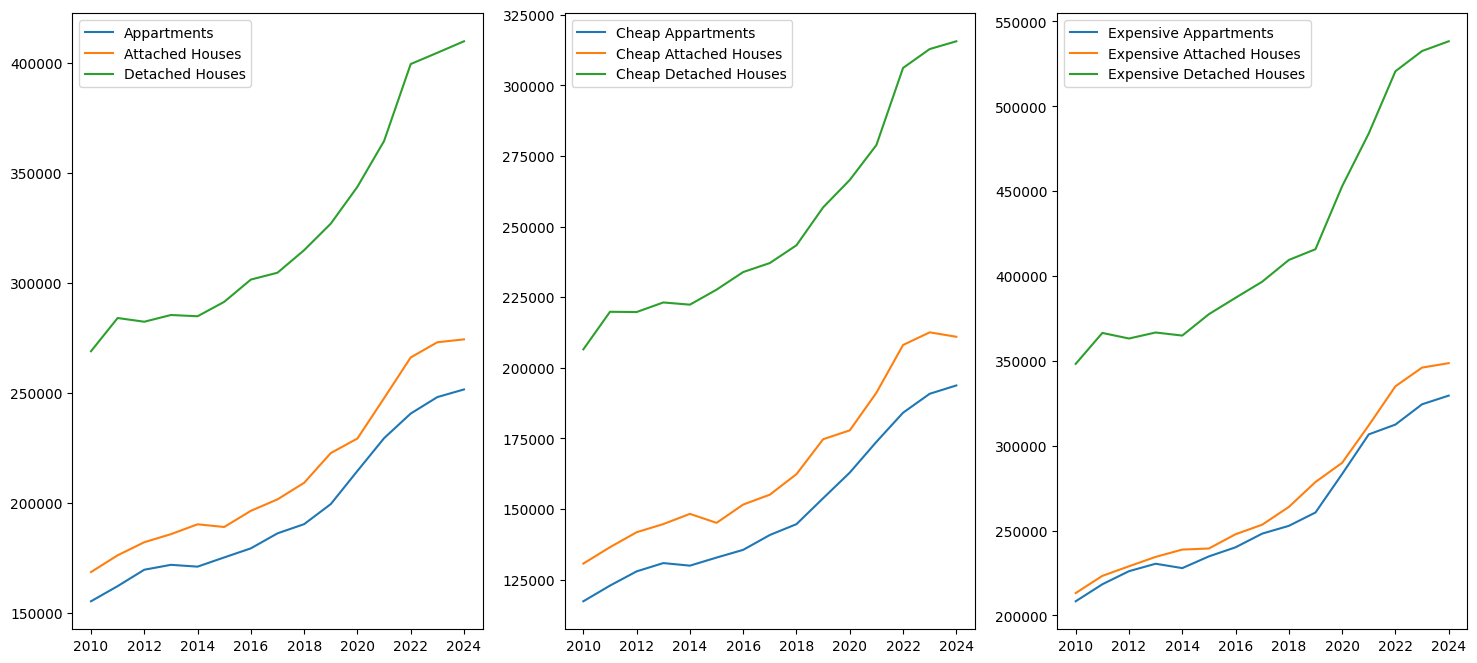

In [245]:
fig, axes = plt.subplots(1,3,figsize=(18,8))

axes[0].plot( all_belg.year,all_belg.q2_3,label="Appartments");
axes[0].plot( all_belg.year,all_belg.q2_1,label="Attached Houses");
axes[0].plot( all_belg.year,all_belg.q2_2,label="Detached Houses");
axes[0].legend();

axes[1].plot( all_belg.year,all_belg.q1_3,label="Cheap Appartments");
axes[1].plot( all_belg.year,all_belg.q1_1,label="Cheap Attached Houses");
axes[1].plot( all_belg.year,all_belg.q1_2,label="Cheap Detached Houses");
axes[1].legend();


axes[2].plot( all_belg.year,all_belg.q3_3,label="Expensive Appartments");
axes[2].plot( all_belg.year,all_belg.q3_1,label="Expensive Attached Houses");
axes[2].plot( all_belg.year,all_belg.q3_2,label="Expensive Detached Houses");
axes[2].legend();

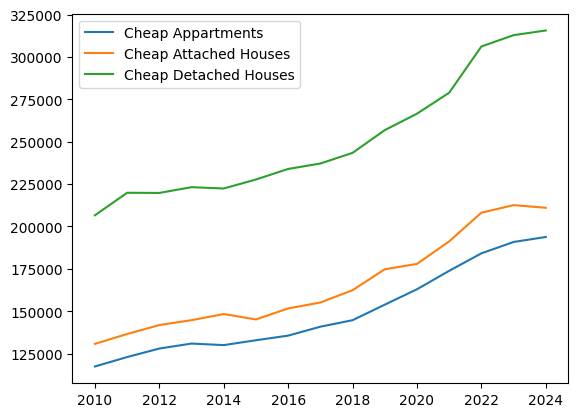

In [244]:
plt.plot( all_belg.year,all_belg.q1_3,label="Cheap Appartments");
plt.plot( all_belg.year,all_belg.q1_1,label="Cheap Attached Houses");
plt.plot( all_belg.year,all_belg.q1_2,label="Cheap Detached Houses");
plt.legend();

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(18,8))

total_sold = (yearly_sales_number["attached_houses"] + yearly_sales_number["detached_houses"] + yearly_sales_number["Appartment"])
attached_frac   = 100* yearly_sales_number["attached_houses"] / total_sold
detached_frac   = 100* yearly_sales_number["detached_houses"] / total_sold
Appartment_frac = 100* yearly_sales_number["Appartment"]      / total_sold

axes[0].plot(yearly_sales_number["attached_houses"],label="Attached Houses");
axes[0].plot(yearly_sales_number["detached_houses"], label="Detached Houses");
axes[0].plot(yearly_sales_number["Appartment"], label="Appartments");
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Properties sold")
axes[0].legend()


axes[1].plot(attached_frac,label="Attached Houses");
axes[1].plot(detached_frac, label="Detached Houses");
axes[1].plot(Appartment_frac, label="Appartments");
axes[1].set_xlabel("Year")
axes[1].set_ylabel("% of total Properties sold")
axes[1].legend();